In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_data, prepare_data_b_ru
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:

# Load datasets
print("Loading data...")
crsp_data, comp_data = load_data()

# Set target variable
target_var = "B12d"
print(f"\nPreparing data for target variable: {target_var}")
merged_data_na, feature_col = prepare_data_b_ru(crsp_data, target_var,n_lags=0)


Loading data...

CRSP Data:
    PERMNO    year  month       ME  B1d  B3d  B6d  B12d  B12m  B36m  B60m  \
0  10006.0  1925.0   12.0  65400.0  NaN  NaN  NaN   NaN   NaN   NaN   NaN   
1  10022.0  1925.0   12.0  11200.0  NaN  NaN  NaN   NaN   NaN   NaN   NaN   
2  10030.0  1925.0   12.0  23400.0  NaN  NaN  NaN   NaN   NaN   NaN   NaN   
3  10057.0  1925.0   12.0   6125.0  NaN  NaN  NaN   NaN   NaN   NaN   NaN   
4  10073.0  1925.0   12.0   2415.0  NaN  NaN  NaN   NaN   NaN   NaN   NaN   

   RU1  RU6  RU12  RU36  vol12  vol36       date  
0  NaN  NaN   NaN   NaN    NaN    NaN 1925-12-01  
1  NaN  NaN   NaN   NaN    NaN    NaN 1925-12-01  
2  NaN  NaN   NaN   NaN    NaN    NaN 1925-12-01  
3  NaN  NaN   NaN   NaN    NaN    NaN 1925-12-01  
4  NaN  NaN   NaN   NaN    NaN    NaN 1925-12-01  

Compustat Data:
    permno    year  month     MEfye        BM      Prof  AG        OL  \
0  10516.0  1950.0    6.0  57633.75  1.375878  0.306076 NaN  2.152420   
1  12511.0  1950.0    6.0  28835.00  1.2

## Predict Beta using Random Forest: 
#### regress R12 using concurrent beta and previous beta
We should that previous beta has significantly lower t-stats than concurrent beta

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import statsmodels.api as sm
import time
from ml_methods import random_forest_model  # Make sure this is defined

def predict_beta_random_forest(merged_data_na, feature_col, window_size=5):
    grouped = merged_data_na.groupby('date')
    sorted_dates = sorted(grouped.groups.keys())

    result_rows = []  # <-- NEW: to collect rows for the resulting DataFrame

    for i in range(window_size, len(sorted_dates)):
        train_dates = sorted_dates[i - window_size:i]
        test_date = sorted_dates[i]

        # try:
        train_groups = [grouped.get_group(d) for d in train_dates if len(grouped.get_group(d)) >= 10]
        if len(train_groups) < window_size:
            continue

        train_data = pd.concat(train_groups)
        test_data = grouped.get_group(test_date)
        if len(test_data) < 10:
            continue

        X_train = train_data[feature_col]
        y_train = train_data["B12d"]
        X_test = test_data[feature_col]
        y_test = test_data["B12d"]
        y_ret = test_data["RU_future"]

        # Train and predict
        _, _, y_pred = random_forest_model(X_train, X_test, y_train, y_test)


        # Store rows for result DataFrame

        temp_df = pd.DataFrame({
            'date': test_date,
            'PERMNO': test_data['PERMNO'],
            'r12': y_ret,
            'b12': y_test,
            'b12_pred': y_pred
        })
        # print(train_data)

        prev_beta = train_data[['PERMNO','B12d']]

        temp_df = temp_df.merge(prev_beta, on='PERMNO', how='left')

        result_rows.append(temp_df)


    # Concatenate all result rows
    result_df = pd.concat(result_rows, ignore_index=True)

    return result_df

res_df = predict_beta_random_forest(merged_data_na, feature_col, window_size=1)

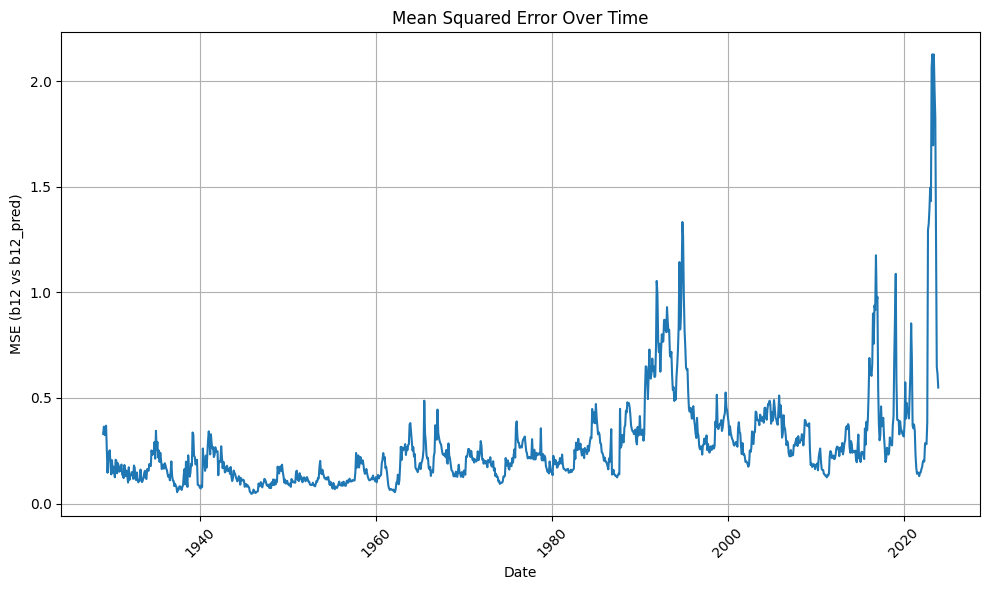

date
1929-01-01    0.329784
1929-02-01    0.364375
1929-03-01    0.324069
1929-04-01    0.357347
1929-05-01    0.368707
                ...   
2023-08-01    1.828911
2023-09-01    1.253378
2023-10-01    0.648455
2023-11-01    0.612390
2023-12-01    0.549168
Name: squared_error, Length: 1140, dtype: float64

In [19]:
import matplotlib.pyplot as plt

def visualize_beta_fit(df):

    # MSE over time
    df['squared_error'] = (df['b12'] - df['b12_pred'])**2
    mse_by_date = df.groupby('date')['squared_error'].mean()

    plt.figure(figsize=(10,6))
    plt.plot(mse_by_date.index, mse_by_date.values)
    plt.xlabel('Date')
    plt.ylabel('MSE (b12 vs b12_pred)')
    plt.title('Mean Squared Error Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mse_by_date

visualize_beta_fit(res_df)

## Down Stream task: regress Return with beta
Look at t-stats(newy west adjusted), predicted beta shows significance at 10% p value

##### Step1: grab coefficient of beta at each time period

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

def newey_west_var(series, lag=3):
    """
    Manually compute Newey-West variance estimator for a 1D series.
    """
    T = len(series)
    gamma_0 = np.sum(series * series) / T
    var = gamma_0

    for l in range(1, lag + 1):
        gamma_l = np.sum(series[l:] * series[:-l]) / T
        weight = 1 - l / (lag + 1)
        var += 2 * weight * gamma_l
    
    return var

def significance_marker(pval):
    """
    Returns a marker for significance level based on p-value.
    """
    if pval < 0.01:
        return '***'  # 1% level
    elif pval < 0.05:
        return '**'   # 5% level
    elif pval < 0.10:
        return '*'    # 10% level
    else:
        return ''

def fama_macbeth_tstats(df, lag=3,silent = False):
    # Store coefficients
    dates = sorted(df['date'].unique())
    coefs_true = []
    coefs_pred = []
    coefs_prev = []

    for d in dates:
        df_d = df[df['date'] == d]
        
        if len(df_d) < 10:
            continue

        # True beta regression
        X_true = sm.add_constant(df_d['b12'])
        model_true = sm.OLS(df_d['r12'], X_true).fit()
        coef_true = model_true.params[1]

        # Predicted beta regression
        X_pred = sm.add_constant(df_d['b12_pred'])
        model_pred = sm.OLS(df_d['r12'], X_pred).fit()
        coef_pred = model_pred.params[1]

        # Predicted beta regression
        try:
            X_pred = sm.add_constant(df_d['B12d'])
            model_pred = sm.OLS(df_d['r12'], X_pred).fit()
            coef_prev = model_pred.params[1]
            coefs_prev.append(coef_prev)
        except:
            pass
        
        coefs_true.append(coef_true)
        coefs_pred.append(coef_pred)
        

    # Convert to Series
    coefs_true = pd.Series(coefs_true, name = "b12_true")
    coefs_pred = pd.Series(coefs_pred, name = "b12_pred")
    coefs_prev = pd.Series(coefs_prev, name = "b12_prev")


    # Average coefficients
    avg_coef_true = coefs_true.mean()
    avg_coef_pred = coefs_pred.mean()
    avg_coef_prev = coefs_prev.mean()

    # Demean
    demeaned_true = coefs_true - avg_coef_true
    demeaned_pred = coefs_pred - avg_coef_pred
    demeaned_prev = coefs_prev - avg_coef_prev

    # Newey-West adjusted variance
    nw_var_true = newey_west_var(demeaned_true, lag=lag)
    nw_var_pred = newey_west_var(demeaned_pred, lag=lag)
    nw_var_prev = newey_west_var(demeaned_prev, lag=lag)

    nw_std_true = np.sqrt(nw_var_true / len(coefs_true))
    nw_std_pred = np.sqrt(nw_var_pred / len(coefs_pred))
    nw_std_prev = np.sqrt(nw_var_prev / len(coefs_prev))

    # New t-stats
    t_stat_true = avg_coef_true / nw_std_true
    t_stat_pred = avg_coef_pred / nw_std_pred
    t_stat_prev = avg_coef_pred / nw_std_prev

    # Degrees of freedom
    df_true = len(coefs_true) - 1
    df_pred = len(coefs_pred) - 1
    df_prev = len(coefs_prev) - 1

    # p-values
    pval_true = 2 * (1 - stats.t.cdf(abs(t_stat_true), df=df_true))
    pval_pred = 2 * (1 - stats.t.cdf(abs(t_stat_pred), df=df_pred))
    pval_prev = 2 * (1 - stats.t.cdf(abs(t_stat_prev), df=df_prev))

    # Significance stars
    sig_true = significance_marker(pval_true)
    sig_pred = significance_marker(pval_pred)
    sig_prev = significance_marker(pval_prev)
    if silent:
        return avg_coef_true, avg_coef_pred, t_stat_true, t_stat_pred, pval_true, pval_pred
    print("=== Fama-MacBeth Style Results ===")
    print(f"[True beta → return]     Avg Coef: {avg_coef_true:.4f}, t-stat: {t_stat_true:.2f}{sig_true}, p-value={pval_true:.4f}")
    print(f"[Predicted beta → return] Avg Coef: {avg_coef_pred:.4f}, t-stat: {t_stat_pred:.2f}{sig_pred}, p-value={pval_pred:.4f}")
    print(f"[prev beta → return] Avg Coef: {avg_coef_prev:.4f}, t-stat: {t_stat_prev:.2f}{sig_prev}, p-value={pval_prev:.4f}")

    return coefs_true,coefs_pred,coefs_prev,pd.Series(dates, name = "date")


In [15]:
# fama_macbeth_tstats(res_df)

coefs_true,coefs_pred,coefs_prev,dates = fama_macbeth_tstats(res_df)
b_coeff = pd.concat([coefs_true,coefs_pred,coefs_prev,dates], axis=1)
b_coeff.head()

=== Fama-MacBeth Style Results ===
[True beta → return]     Avg Coef: 0.0413, t-stat: 3.54***, p-value=0.0004
[Predicted beta → return] Avg Coef: 0.0283, t-stat: 1.61, p-value=0.1086
[prev beta → return] Avg Coef: 0.0834, t-stat: 0.52, p-value=0.6032


,b12_true,b12_pred,b12_prev,date
0,-0.024957,-0.181074,-0.127322,1929-01-01
1,-0.032093,-0.205259,-0.200511,1929-02-01
2,-0.007008,-0.150658,0.409463,1929-03-01
3,-0.017288,-0.193510,0.199531,1929-04-01
4,0.007154,-0.114745,0.105626,1929-05-01


##### Step2: test if coefficient is significant

In [16]:
def compute_series_tstat(series, lag=3, silent=False):
    """
    Compute the average, Newey-West adjusted standard error, t-stat, and p-value for a series.
    
    Args:
        series (pd.Series): A 1D array-like of regression coefficients over time.
        lag (int): Lag length for Newey-West adjustment.
        silent (bool): If True, suppress printout.
    
    Returns:
        avg_coef, t_stat, pval
    """
    series = pd.Series(series).dropna()

    avg_coef = series.mean()
    demeaned = series - avg_coef

    nw_var = newey_west_var(demeaned, lag=lag)
    nw_std = np.sqrt(nw_var / len(series))

    t_stat = avg_coef / nw_std
    dfree = len(series) - 1
    pval = 2 * (1 - stats.t.cdf(abs(t_stat), df=dfree))

    sig = significance_marker(pval)

    if not silent:
        print(f"Avg Coef: {avg_coef:.4f}, t-stat: {t_stat:.2f}{sig}, p-value={pval:.4f}")

    return avg_coef, t_stat, pval



##### Step3: Visualize P Value over time

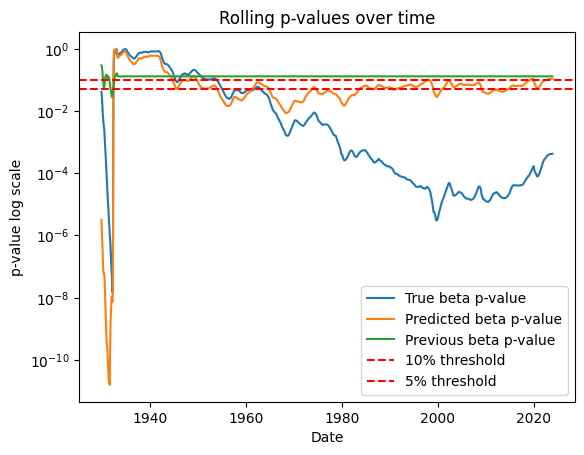

In [17]:
# Rolling computation
results = []
for idx in range(10, len(b_coeff)):  # Start after minimum of 10 samples
    subset = b_coeff.iloc[:idx+1]

    # Compute stats for true and pred
    avg_true, tstat_true, pval_true = compute_series_tstat(subset['b12_true'], silent=True)
    avg_pred, tstat_pred, pval_pred = compute_series_tstat(subset['b12_pred'], silent=True)
    avg_prev, tstat_prev, pval_prev = compute_series_tstat(subset['b12_prev'], silent=True)

    results.append({
        'date': subset['date'].iloc[-1],
        'pval_true': pval_true,
        'pval_pred': pval_pred,
        'pval_prev': pval_prev,
        'tstat_true': tstat_true,
        'tstat_pred': tstat_pred,
        'tstat_prev': tstat_prev,
        'avg_true': avg_true,
        'avg_pred': avg_pred,
        'avg_prev': avg_prev,
    })

# Convert to DataFrame
rolling_pvals = pd.DataFrame(results)

# Example: plot p-values
import matplotlib.pyplot as plt

plt.plot(rolling_pvals['date'], rolling_pvals['pval_true'], label='True beta p-value')
plt.plot(rolling_pvals['date'], rolling_pvals['pval_pred'], label='Predicted beta p-value')
plt.plot(rolling_pvals['date'], rolling_pvals['pval_prev'], label='Previous beta p-value')
plt.axhline(0.1, color='red', linestyle='--', label='10% threshold')
plt.yscale('log')
plt.axhline(0.05, color='red', linestyle='--', label='5% threshold')
plt.legend()
plt.title('Rolling p-values over time')
plt.xlabel('Date')
plt.ylabel('p-value log scale')
plt.show()

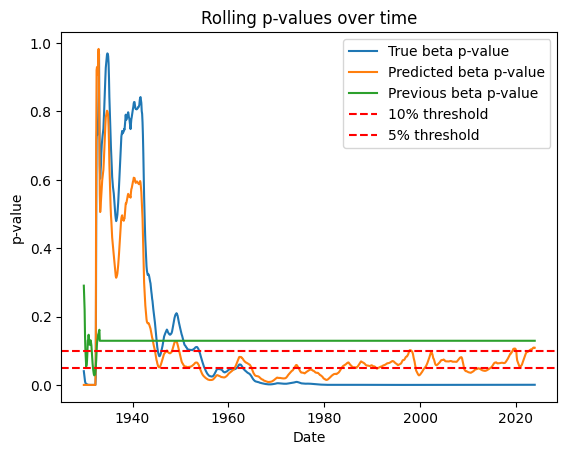

In [72]:
plt.plot(rolling_pvals['date'], rolling_pvals['pval_true'], label='True beta p-value')
plt.plot(rolling_pvals['date'], rolling_pvals['pval_pred'], label='Predicted beta p-value')
plt.plot(rolling_pvals['date'], rolling_pvals['pval_prev'], label='Previous beta p-value')
plt.axhline(0.1, color='red', linestyle='--', label='10% threshold')

plt.axhline(0.05, color='red', linestyle='--', label='5% threshold')
plt.legend()
plt.title('Rolling p-values over time')
plt.xlabel('Date')
plt.ylabel('p-value')
plt.show()